In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import scipy.integrate as integrate

In [2]:
def baseline(vals, n_low, n_high):
    vals_low = vals[:n_low]
    vals_high = vals[(vals.size - n_high):-1]
    vals_mean = ( np.sum(vals_low) + np.sum(vals_high) ) / ( vals_low.size + vals_high.size )
    return vals_mean

In [3]:
from scipy.special import erfc

def model_exp_gaus_res(x, *pars):
    C = pars[0]
    t0 = pars[1]
    sigma = pars[2]
    A = pars[3]
    tau = pars[4]
    
    val = A * ( 1./(2*tau) ) * np.exp( (sigma**2)/(2*(tau**2)) - (x - t0)/tau ) * erfc( sigma/(np.sqrt(2.)*tau) - (x - t0)/(np.sqrt(2.)*sigma) ) 
    val += C
    
    return val

class ModelExpRCRes:
    #def __init__(self, sigma=None):
    #    self.sigma = sigma
    def __call__(self, x, *pars):
        C = pars[0]
        t0 = pars[1]
        sigma = pars[2]
        A = pars[3]
        tau_0 = pars[4]
        a_1 = pars[5]
        tau_1 = pars[6]
    
        a   = np.array( ( (1. - a_1), a_1) )
        tau = np.array( (tau_0, tau_1) )
        
        val = ( ( a[0]/(2*tau[0]) ) * np.exp( (sigma**2)/(2*(tau[0]**2)) - (x - t0)/tau[0] ) * erfc( sigma/(np.sqrt(2.)*tau[0]) - (x - t0)/(np.sqrt(2.)*sigma) ) + 
            ( a[1]/(2*tau[1]) ) * np.exp( (sigma**2)/(2*(tau[1]**2)) - (x - t0)/tau[1] ) * erfc( sigma/(np.sqrt(2.)*tau[1]) - (x - t0)/(np.sqrt(2.)*sigma) ) )                
             
        val *= A
        val += C
    
        return val  
        

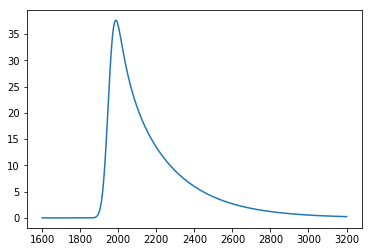

In [4]:
x_min = 1600
x_max = 3200
    
x_data_lin = np.linspace(x_min,x_max,1000)

func_ = ModelExpRCRes()

y_data_func = func_(x_data_lin, 0., 1950., 25., 10000., 50., 0.90, 250.)

plt.plot(x_data_lin, y_data_func)

In [5]:
def fit_function(func_, p0_, bounds_, x_data, y_data):
    
    popt, pcov = curve_fit( func_, x_data, y_data, p0=p0_, bounds=bounds_ )

    return ( popt, pcov )    

In [6]:
def fit_event(event, debug=True, i_xmin=400, i_xmax=800):
    event_cpy = event.copy()
    
    val_baseline = baseline(event_cpy, 200, 200)
    if debug: 
        print ( "Baseline: {:.2f}".format( val_baseline ) )
        print ( "\n" )
    
    invert = True
    if invert:
        event_cpy -= val_baseline
        event_cpy *= -1
        
    #i_xmin=400
    #i_xmax=800
    
    x_data_range = np.arange(i_xmin,i_xmax)*4.
    
    x_min = x_data_range[0]
    x_max = x_data_range[-1]
    
    if debug: 
        print (x_min, x_max)
        print ( "\n" )
    
    event_range = event_cpy[i_xmin:i_xmax]
    
    event_range[ (event_range < 0) ] = 0
    
    if debug: 
        print ( event_range )
        print ( "\n" )
        print ( np.sqrt(event_range) )
        print ( "\n" )
    
    p0_def_exp_gaus_res = (0., 1950., 20., 10000., 250.)
    
    bounds_exp_gaus_res = ( (-np.inf,     0.,     0.,     0.,     0.),
                            ( np.inf, np.inf, np.inf, np.inf, np.inf) )
    
    if debug: 
        print( p0_def_exp_gaus_res, bounds_exp_gaus_res )
        print ( "\n" )
        
    try:
        popt_0, pcov_0 = fit_function(model_exp_gaus_res, p0_def_exp_gaus_res, bounds_exp_gaus_res, x_data_range, event_range)
    except (RuntimeError, ValueError) as err:
        print( err )
        print ( "\n" )
        popt_0 = np.zeros(5)
        pcov_0 = np.zeros((5,5))
        
    if debug: 
        print( popt_0, pcov_0 )
        print ( "\n" )
    
    if (popt_0 == np.zeros(5)).all() == True:
        return (None, None, None, None, None, None, x_data_range, event_range)
    
    model_exp_RC_res = ModelExpRCRes()
    
    p0_exp_RC_res = list(popt_0[0:4]) + [20.,0.50] + [ popt_0[4] ]
    
    bounds_exp_RC_res = ( (-np.inf,     0.,     0.,     0.,     0., 0.,     0.),
                          ( np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf) )
    
    if debug: 
        print ( p0_exp_RC_res, bounds_exp_RC_res )
        print ( "\n" )
    
    try:
        popt_1, pcov_1 = fit_function(model_exp_RC_res, p0_exp_RC_res, bounds_exp_RC_res, x_data_range, event_range)
    except (RuntimeError, ValueError) as err:
        print( err )
        print ( "\n" )
        popt_1 = np.zeros(7)
        pcov_1 = np.zeros((7,7))
        
    if debug: 
        print( popt_1, pcov_1 )
        print ( "\n" )     
    
    if (popt_1 == np.zeros(7)).all() == True: 
        return (None, None, None, None, None, None, x_data_range, event_range)
    
    x_data_lin = np.linspace(x_min,x_max,1000)
    
    pars_no_baseline_0 = [0.] + list( popt_0[1:] )
    
    func_0 = lambda x: model_exp_gaus_res(x, *pars_no_baseline_0)
    
    func_0_full = lambda x: model_exp_gaus_res(x, *popt_0)
    
    pars_no_baseline_1 = [0.] + list( popt_1[1:] )
    
    func_1 = lambda x: model_exp_RC_res(x, *pars_no_baseline_1)
    
    func_1_full = lambda x: model_exp_RC_res(x, *popt_1)
    
    if debug:
        plt.figure(figsize=(10,5))
        plt.plot( x_data_range, event_range, 'ko' )
        #plt.plot( x_data_range, model_exp_gaus_res(x_data_range, *popt) )
        plt.plot( x_data_lin, func_0_full(x_data_lin) )
        plt.plot( x_data_lin, func_1_full(x_data_lin) )
        plt.plot( x_data_lin, func_0(x_data_lin) )
        plt.plot( x_data_lin, func_1(x_data_lin) )
        
    chi2 = np.sum( ( event_range - func_1_full(x_data_range) )**2 ) / len(event_range)
    if debug: 
        print (chi2)
        print ( "\n" )
        
    integral_result = integrate.quad( func_1, x_min, x_max )
    if debug: 
        print (integral_result)
        print ( "\n" )
    
    threshold = 30.
    x_threshold_binned = -1.
    x_sel_binned = x_data_range[event_range > threshold]
    if x_sel_binned.size > 0: x_threshold_binned = x_sel_binned[0]
    if debug: 
        print (x_threshold_binned)
        print ( "\n" )
    
    x_threshold_func = -1.
    x_sel_func = x_data_lin[func_1(x_data_lin) > threshold]
    if x_sel_func.size > 0: x_threshold_func = x_sel_func[0]
    if debug: 
        print (x_threshold_func)
        print ( "\n" )
    
    #return (chi2, integral_result, x_threshold_binned, x_threshold_func, popt_1, pcov_1)
    return (chi2, integral_result, x_threshold_binned, x_threshold_func, popt_1, pcov_1, x_data_range, event_range)

In [7]:
#df = pd.read_hdf("../output.h5",'df')
df = pd.read_hdf("../output-wave-06-11-2019.h5",'df')

print ( "Size: {}".format(df.shape[0]) )

Size: 3000


In [8]:
i_evt = 84
event = df.loc[i_evt,'Vals']

result = fit_event(event, True)
print (result)


Baseline: 2048.86


1600.0 3196.0


[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.85964912   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           1.85964912  11.85964912
  14.85964912  29.85964912  41.85964912  51.85964912  62.85964912
  72.85964912  76.85964912  77.85964912  85.85964912  87.85964912
  96.85964912  94.85964912  87.85964912  91.85964912  88.85964912
  94.85964912  92.85964912  78.85964912  90.85964912  99.85964912
  98.85964912 104.85964912  92.85964912  88.85964912  99.85964912
 100.85964912 100.85964912 101.85964912  93.85

Optimal parameters not found: The maximum number of function evaluations is exceeded.


[0. 0. 0. 0. 0. 0. 0.] [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


(None, None, None, None, None, None, array([1600., 1604., 1608., 1612., 1616., 1620., 1624., 1628., 1632.,
       1636., 1640., 1644., 1648., 1652., 1656., 1660., 1664., 1668.,
       1672., 1676., 1680., 1684., 1688., 1692., 1696., 1700., 1704.,
       1708., 1712., 1716., 1720., 1724., 1728., 1732., 1736., 1740.,
       1744., 1748., 1752., 1756., 1760., 1764., 1768., 1772., 1776.,
       1780., 1784., 1788., 1792., 1796., 1800., 1804., 1808., 1812.,
       1816., 1820., 1824., 1828., 1832., 1836., 1840., 1844., 1848.,
       1852., 1856., 1860., 1864., 1868., 1872., 1876., 1880., 1884.,
       1888., 1892., 1896., 1900., 1904., 1908., 1912., 1916., 1920.,
       1924., 1928., 1932., 1936., 1940., 1944., 19

Size: 3000
Event:  0
Event:  1
Event:  2
Event:  3
Event:  4
Event:  5
Event:  6
Event:  7
Event:  8
Event:  9
Event:  10
Event:  11
Event:  12


/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


Event:  13
Event:  14
Event:  15
Event:  16
Event:  17
Event:  18
Event:  19
Event:  20
Event:  21
Event:  22
Event:  23
Event:  24
Event:  25
Event:  26
Event:  27
Event:  28
Event:  29
Event:  30
Event:  31
Event:  32
Event:  33
Event:  34
Event:  35
Event:  36
Event:  37
Event:  38
Event:  39
Event:  40
Event:  41
Event:  42
Event:  43
Event:  44
Event:  45
Event:  46
Event:  47
Event:  48
Event:  49
Event:  50
Event:  51
Event:  52
Event:  53
Event:  54
Event:  55
Event:  56
Event:  57
Event:  58
Event:  59
Event:  60
Event:  61
Event:  62
Event:  63
Event:  64
Event:  65
Event:  66
Event:  67
Event:  68
Event:  69
Event:  70
Event:  71
Event:  72
Event:  73
Event:  74
Event:  75
Event:  76
Event:  77
Event:  78
Event:  79
Event:  80
Event:  81
Event:  82
Event:  83
Event:  84
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  85
Event:  86
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  87

/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


Event:  94
Event:  95
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  96
Event:  97
Event:  98
Event:  99
Event:  100
Event:  101
Event:  102
Event:  103
Event:  104
Event:  105
Event:  106
Event:  107
Event:  108
Event:  109
Event:  110


/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


Event:  111
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  112
Event:  113
Event:  114
Event:  115
Event:  116
Event:  117
Event:  118
Event:  119
Event:  120
Event:  121
Event:  122
Event:  123
Event:  124
Event:  125
Event:  126
Event:  127
Event:  128
Event:  129
Event:  130
Event:  131
Event:  132
Event:  133
Event:  134
Event:  135
Event:  136
Event:  137
Event:  138
Event:  139
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  140
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  141
Event:  142
Event:  143
Event:  144
Optimal parameters not found: The maximum number of function evaluations is exceeded.


Event:  145
Event:  146
Event:  147
Event:  148
Event:  149
Event:  150
Event:  151
Event:  152
Event:  153
Event:  154
Event:  155
Event:  156
Event:  157
Event:  158
Event:  159
Event:  160
Event:  161
Event:  162
Optimal parameters not f

(array([ 1.,  0.,  1.,  4.,  3.,  0.,  2.,  3.,  2.,  3.,  6.,  8.,  4.,
         4.,  4.,  7.,  6., 34., 30., 15., 17., 13., 12.,  3.,  6., 14.,
        14., 17., 33., 34., 39., 15., 22., 14.,  6.,  6.,  7.,  4.,  1.,
         5.,  4.,  3.,  2.,  4.,  2.,  4.,  0.,  2.,  3.,  1.]),
 array([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160.,
        176., 192., 208., 224., 240., 256., 272., 288., 304., 320., 336.,
        352., 368., 384., 400., 416., 432., 448., 464., 480., 496., 512.,
        528., 544., 560., 576., 592., 608., 624., 640., 656., 672., 688.,
        704., 720., 736., 752., 768., 784., 800.]),
 <a list of 50 Patch objects>)

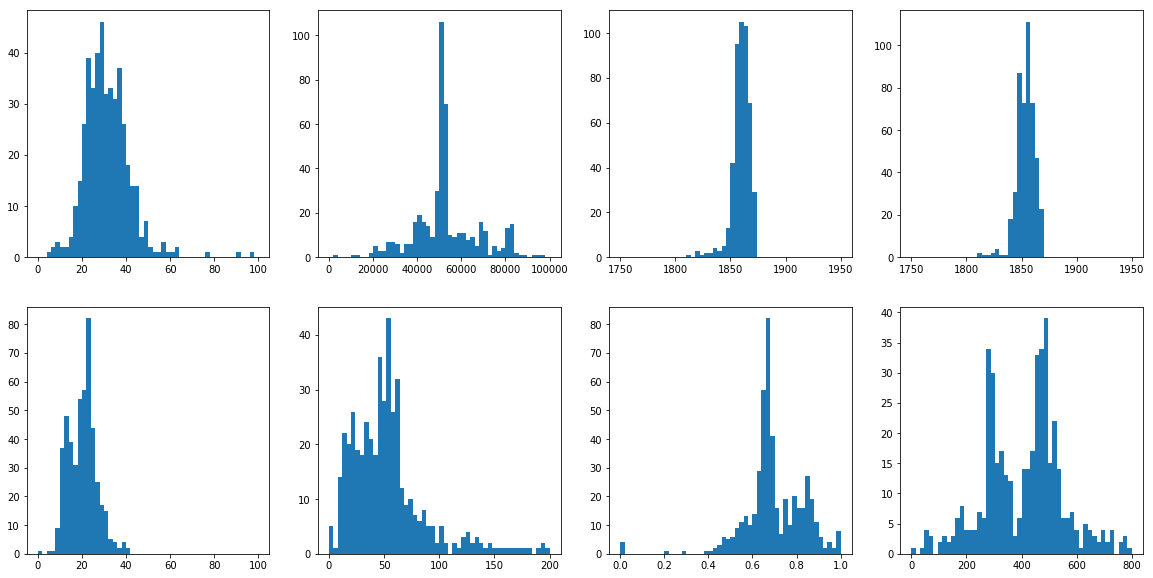

In [9]:
df = pd.read_hdf("../output-wave-06-11-2019.h5",'df')
print ( "Size: {}".format(df.shape[0]) )

maxEvents = 500

chi2_vals = []
integral_vals = []
x_leading_binned_vals = []
x_leading_func_vals = []
sigma_vals = []
tau_0_vals = []
a_1_vals = []
tau_1_vals = []

for i in range( df.shape[0] ):
    if maxEvents >= 0 and i >= maxEvents: break
    
    print ("Event: ", i)
    event = df.loc[i,'Vals']
    
    result = fit_event(event, False)
    if not result[0]: continue
        
    chi2, integral_result, x_threshold_binned, x_threshold_func, popt, pcov, x_data_range, event_range = result
    chi2_vals.append( chi2 )
    integral_vals.append( integral_result[0] )
    x_leading_binned_vals.append( x_threshold_binned )
    x_leading_func_vals.append( x_threshold_func )
    sigma_vals.append( popt[2] )
    tau_0_vals.append( popt[4] )
    a_1_vals.append( popt[5] )
    tau_1_vals.append( popt[6] )

fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes[0,0].hist( chi2_vals, bins=50, range=(0., 100.) )
axes[0,1].hist( integral_vals, bins=50, range=(0., 100.e+03) )
axes[0,2].hist( x_leading_binned_vals, bins=50, range=(1750., 1950.) )
axes[0,3].hist( x_leading_func_vals, bins=50, range=(1750., 1950.) )
axes[1,0].hist( sigma_vals, bins=50, range=(0.,100.) )
axes[1,1].hist( tau_0_vals, bins=50, range=(0., 200.) )
axes[1,2].hist( a_1_vals, bins=50, range=(0., 1.) )
axes[1,3].hist( tau_1_vals, bins=50, range=(0., 800.) )


Size: 3000
Event:  527
Event:  91
Event:  2940
Event:  316
Event:  526
Event:  1720


/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


Event:  2658
Event:  2929
Event:  1461
Event:  1345
Event:  457
Event:  2625
Event:  2280
Event:  1927


/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


Event:  2319
Event:  1504


/Users/antoniovilelapereira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


Optimal parameters not found: The maximum number of function evaluations is exceeded.




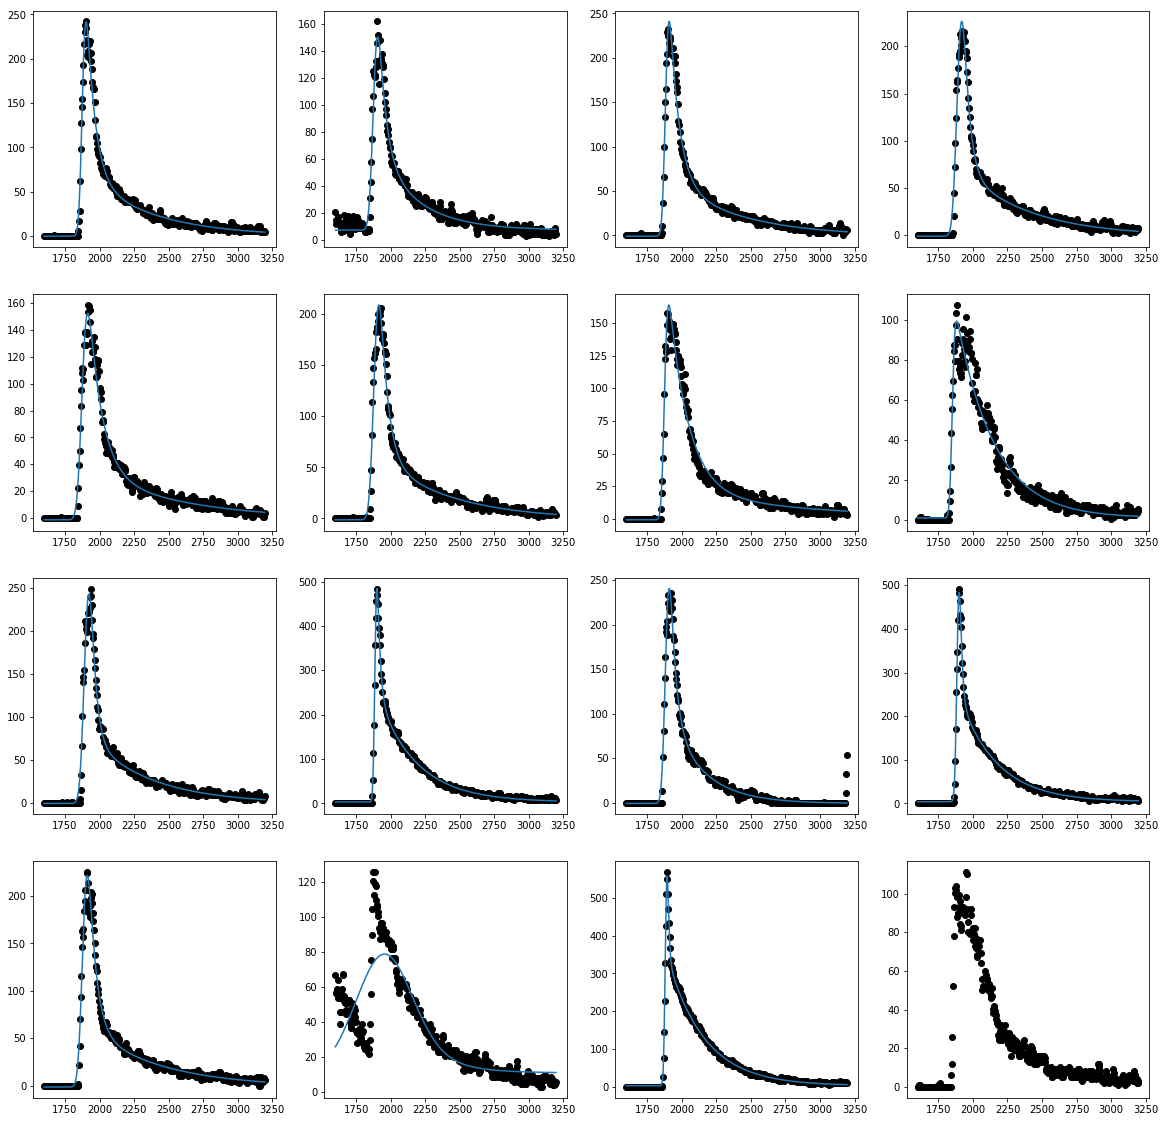

In [10]:
df = pd.read_hdf("../output-wave-06-11-2019.h5",'df')

number_of_events = df.shape[0]
print ( "Size: {}".format( number_of_events ) )

model_exp_RC_res = ModelExpRCRes()

rows = 4
cols = 4
event_numbers = np.random.randint( 0, number_of_events, ( rows*cols) )

fig, axes = plt.subplots(rows, cols, figsize=(20,20))

i_row = 0
i_col = 0
for i in event_numbers:
    print ("Event: ", i)
    event = df.loc[i,'Vals']
    
    result = fit_event(event, False)
    
    chi2, integral_result, x_threshold_binned, x_threshold_func, popt, pcov, x_data_range, event_range = result
    
    axes[i_row, i_col].plot( x_data_range, event_range, 'ko' )
    
    if chi2:
        func_ = lambda x: model_exp_RC_res(x, *popt)
    
        x_min = x_data_range[0]
        x_max = x_data_range[-1]
        x_data_lin = np.linspace(x_min,x_max,1000)
    
        axes[i_row, i_col].plot( x_data_lin, func_(x_data_lin) )
    
    i_col += 1
    if i_col >= cols:
        i_row += 1
        i_col = 0
        